In [3]:
import uproot
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import progressbar
from scipy.interpolate import interp1d

In [4]:
calcValues = False

## Berechnung der Integralmatrix 

In [4]:
mainPath = "/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/TEST_FOLDER_MASS/"
testFoldersTmp = []
for filename in sorted(os.listdir(mainPath)):
    testFoldersTmp.append(filename)
testFolders = (np.sort(np.array(testFoldersTmp).astype(int))).astype(str)

In [5]:
def prepareArray(origArray):
    preparedArray = np.zeros(len(origArray), dtype=complex)
    for i in range(0, len(origArray)):
        preparedArray[i] = origArray[i][0]
    return preparedArray

In [7]:
nmbTestFolders = len(testFolders)

nmbWaves = len([name for name in os.listdir(mainPath + testFolders[0] + '/amps/') if os.path.isfile(os.path.join(mainPath + testFolders[0] + '/amps/', name))])
axisArr = np.zeros(nmbTestFolders, dtype=int)
integralMatrix = np.zeros((nmbWaves, nmbWaves), dtype = np.ndarray)
errorMatrixAbsolut = np.zeros((nmbWaves, nmbWaves), dtype = np.ndarray)
errorMatrixRelativ = np.zeros((nmbWaves, nmbWaves), dtype = np.ndarray)
for i in range(0, nmbWaves):
    for j in range(0, nmbWaves):
        integralMatrix[i][j] = np.zeros(nmbTestFolders, dtype=complex)
        errorMatrixAbsolut[i][j] = np.zeros(nmbTestFolders, dtype=complex)
        errorMatrixRelativ[i][j] = np.zeros(nmbTestFolders, dtype=complex)


bar = progressbar.ProgressBar(maxval=nmbTestFolders, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for folderI in range(0,nmbTestFolders):
    ampPath = mainPath + testFolders[folderI] + '/amps/'
    bar.update(folderI+1)
    #print testFolders[folderI][16:]
    axisArr[folderI] = testFolders[folderI]




    onlyfiles = []
    for filename in sorted(os.listdir(ampPath)):
        onlyfiles.append(filename)
    nmbWaves = len(onlyfiles)
    ampFile1 = uproot.open(ampPath + onlyfiles[0])
    nmbEvents = len(ampFile1[ampFile1.keys()[0]]['amplitude'].get('_incohSubAmps._real').array())
    sd = np.zeros((nmbWaves, nmbWaves), dtype = complex)
    ampMatrix = np.zeros((nmbWaves,nmbEvents), dtype = complex)



    for waveIndexI in range(0, nmbWaves):
        if ampMatrix[waveIndexI].all() == 0:
            ampFile1 = uproot.open(ampPath + onlyfiles[waveIndexI])
            key1 = ampFile1.keys()[0]

            incohSubAmpsReal1 = ampFile1[key1]['amplitude'].get('_incohSubAmps._real').array()
            incohSubAmpsImag1 = ampFile1[key1]['amplitude'].get('_incohSubAmps._imag').array()
            ampMatrix[waveIndexI] = prepareArray(np.array(incohSubAmpsReal1 + 1j * incohSubAmpsImag1))
            #print ampMatrix[waveIndexI]
            #raise ValueError('Exit.')




        for waveIndexJ in range(0, waveIndexI + 1): #nmbWaves):
            if ampMatrix[waveIndexJ].all() == 0:
                ampFile2 = uproot.open(ampPath + onlyfiles[waveIndexJ])
                key2 = ampFile2.keys()[0]

                incohSubAmpsReal2 = ampFile2[key2]['amplitude'].get('_incohSubAmps._real').array()
                incohSubAmpsImag2 = ampFile2[key2]['amplitude'].get('_incohSubAmps._imag').array()
                ampMatrix[waveIndexJ] = prepareArray(np.array(incohSubAmpsReal2 + 1j * incohSubAmpsImag2))

            integral = np.sum(ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate())/nmbEvents 

            sdReal = sum(pow((ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate()).real, 2)).real
            sdImag = sum(pow((ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate()).imag, 2)).real
            #print "Var1:", sdReal
            
            
            sdReal = math.sqrt(sdReal/float(nmbEvents) - pow(integral.real,2))
            sdImag = math.sqrt(sdImag/float(nmbEvents) - pow(integral.imag,2))
            sdComplex = complex(sdReal, sdImag)        
            errorComplex = complex(sdReal/math.sqrt(nmbEvents), sdImag/math.sqrt(nmbEvents))

            sd[waveIndexI][waveIndexJ] = sdComplex
            sd[waveIndexJ][waveIndexI] = sdComplex
   
            #print "%i, %i, %i: %s, %s, %s" %(folderI, waveIndexI, waveIndexJ, integral, sd[waveIndexI][waveIndexJ], errorComplex)
            #print np.cov(amp/nmbEvents)
            #raise ValueError('Exit.')

            integralMatrix[waveIndexI][waveIndexJ][folderI] = integral
            errorMatrixAbsolut[waveIndexI][waveIndexJ][folderI] = errorComplex
            errorMatrixAbsolut[waveIndexJ][waveIndexI][folderI] = errorComplex

            if waveIndexI == waveIndexJ:
                errorMatrixRelativ[waveIndexI][waveIndexJ][folderI] = complex(errorComplex.real/math.fabs(integral.real), 0)
            else:
                errorMatrixRelativ[waveIndexI][waveIndexJ][folderI] = complex(errorComplex.real/math.fabs(integral.real), errorComplex.imag/math.fabs(integral.imag))
                errorMatrixRelativ[waveIndexJ][waveIndexI][folderI] = complex(errorComplex.real/math.fabs(integral.real), errorComplex.imag/math.fabs(integral.imag))


print "Finish calculation successfully"

Finish calculation successfully


In [ ]:
if calcValues == True:
    fileName = 'Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_100.npy'
    np.save(fileName, np.array([(axisArr, onlyfiles, integralMatrix, errorMatrixAbsolut, errorMatrixRelativ)]))
    print "Finish application successfully to file:", fileName

# Auswertung
## Lade Daten

In [5]:
if calcValues == False:
    axisArr, onlyfiles, integralMatrix, errorMatrixAbsolut, errorMatrixRelativ = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_20.npy')[0]
    axisArr1, onlyfiles1, integralMatrix1, errorMatrixAbsolut1, errorMatrixRelativ1 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3020_60.npy')[0]
    axisArr2, onlyfiles2, integralMatrix2, errorMatrixAbsolut2, errorMatrixRelativ2 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_100.npy')[0]

0 0
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


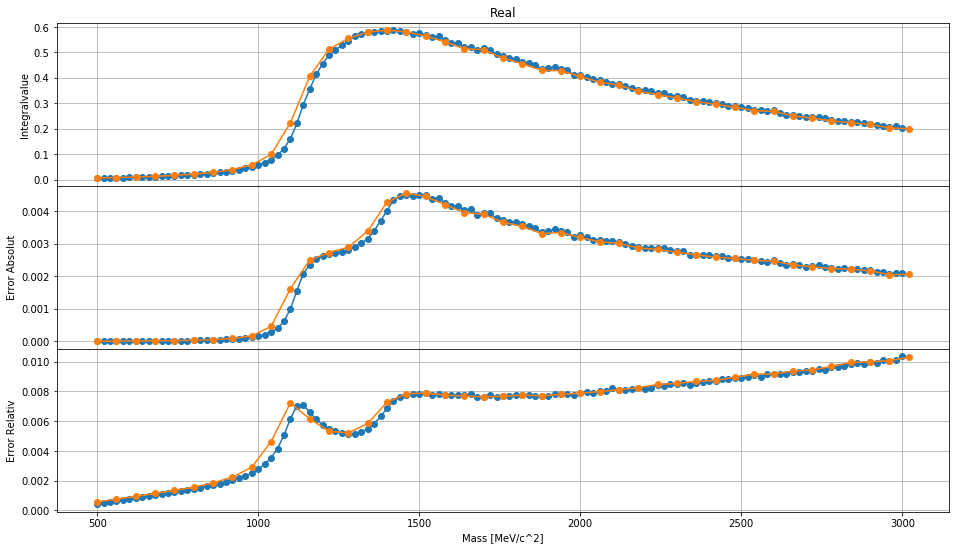

1 0
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


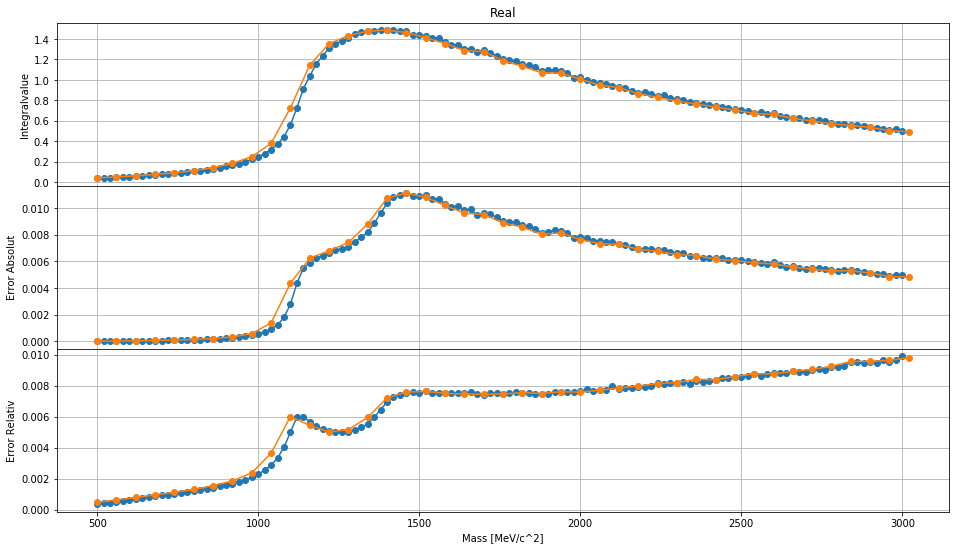

[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


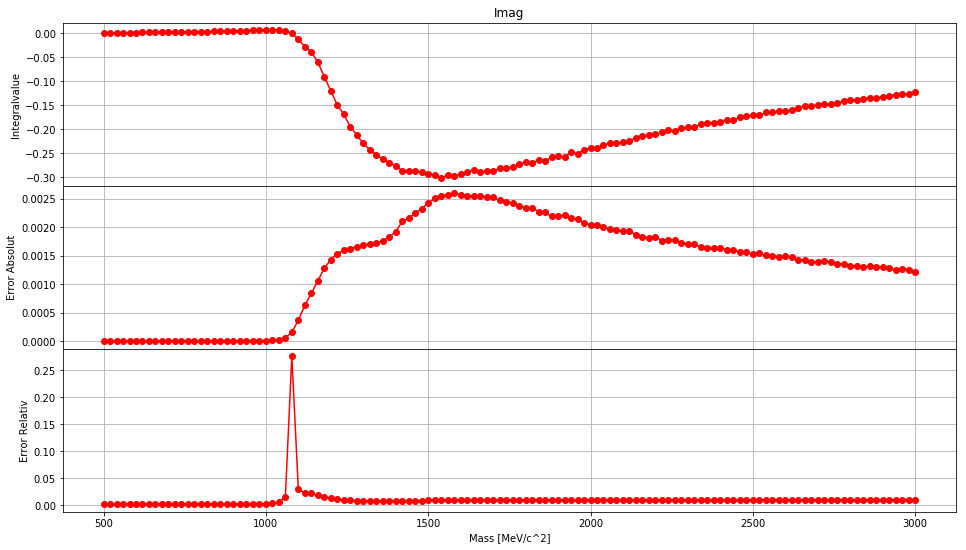

1 1
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


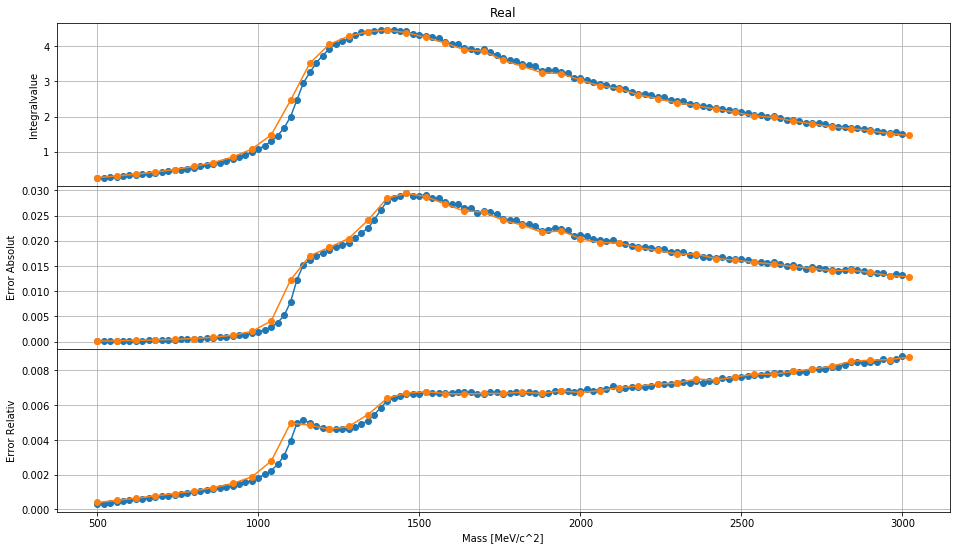

2 0
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


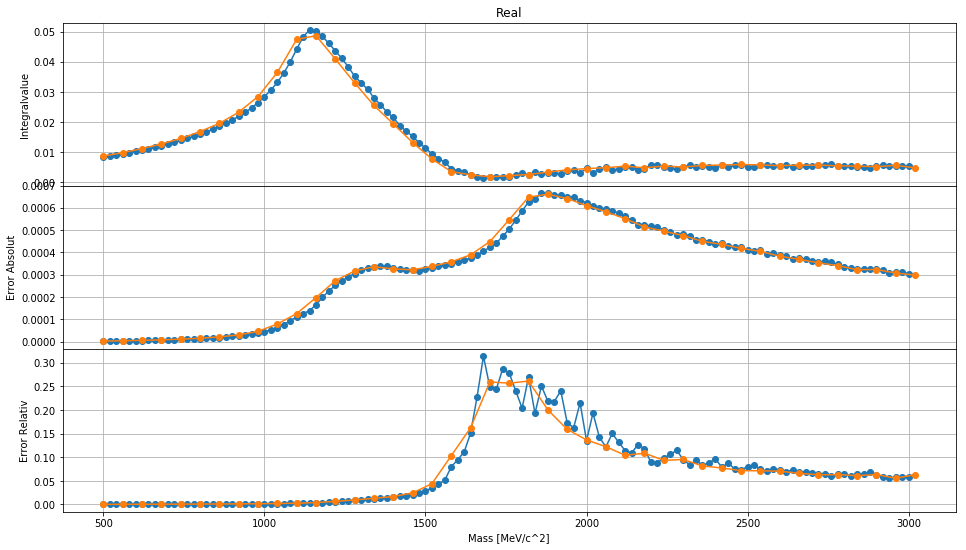

[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


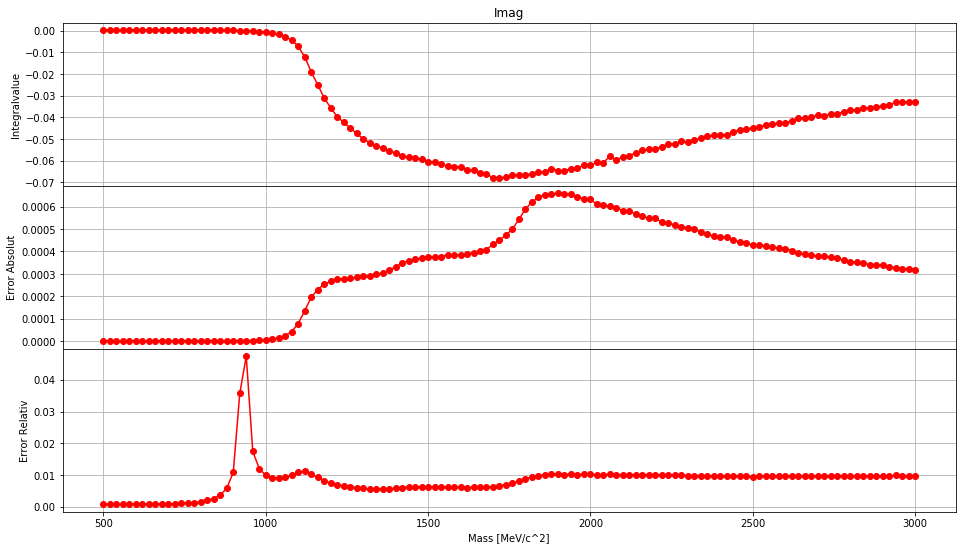

2 1
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


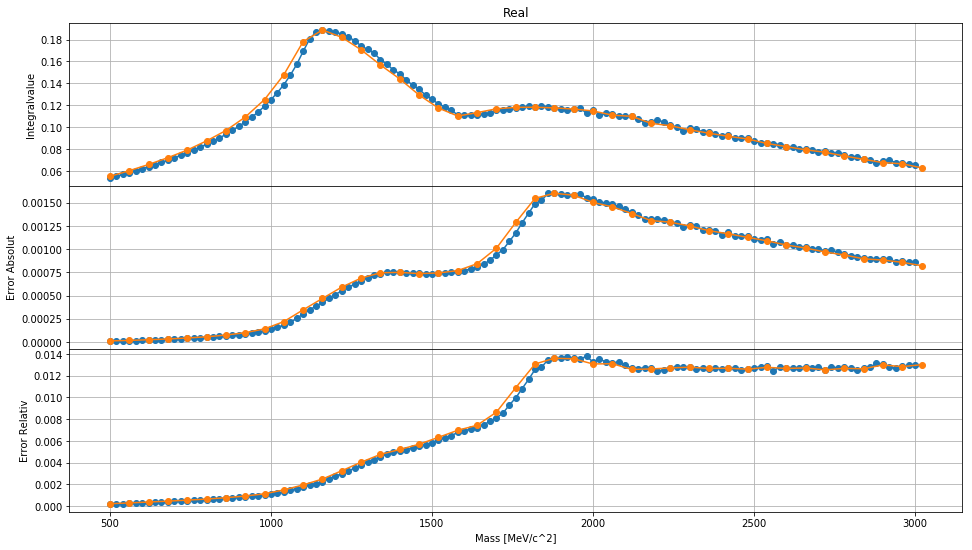

[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


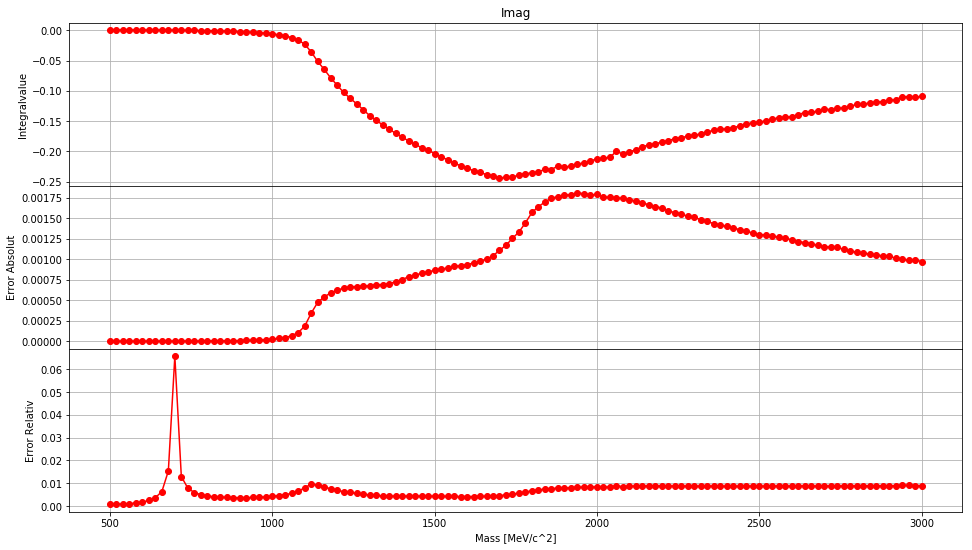

2 2
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


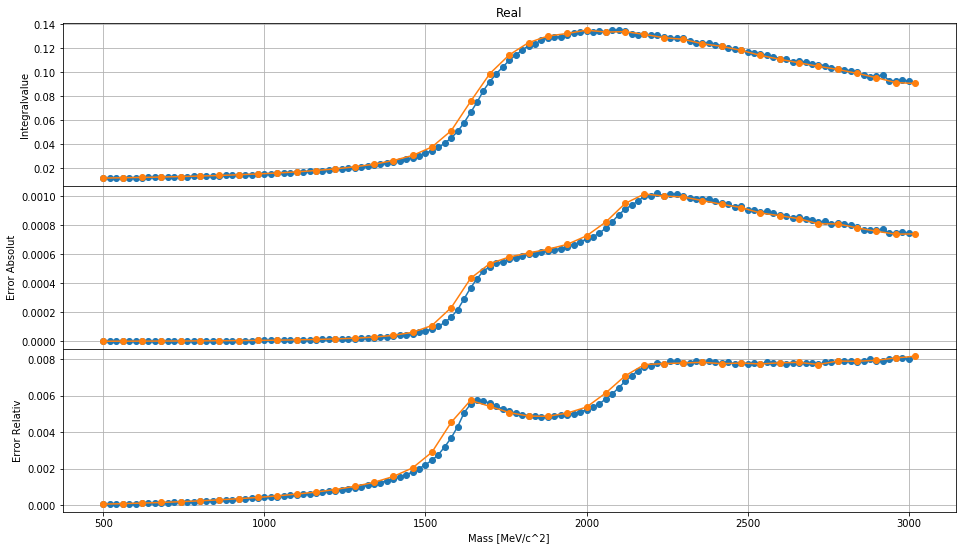

3 0
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


KeyboardInterrupt: 

In [124]:
if calcValues == False:
    for i in range(0,10): #len(errorMatrixAbsolut)):
        for j in range(0, i+1):
            print i, j
            print onlyfiles[i]
            print onlyfiles[j]
            
            f = plt.figure(figsize=(16,9))
            plt.subplots_adjust(hspace=0.001)

            ax1 = plt.subplot(311)
            ax1.grid(True)
            #plt.xticks(np.arange(0, max(axisArr), 1000))
            #ax1.set_xticks(np.arange(0, max(axisArr), 1000))
            ax1.plot(axisArr, integralMatrix[i][j].real, 'o-')
            ax1.plot(axisArr1, integralMatrix1[i][j].real, 'o-')
            plt.title("Real")
            plt.ylabel('Integralvalue')
            #plt.ylim(min(integralMatrix[i][j]).imag*.5, max(integralMatrix[i][j]).imag*1.2)

            ax2 = plt.subplot(312, sharex=ax1)
            ax2.grid(True)
            #plt.xticks(np.arange(0, max(axisArr), 1000))
            ax2.plot(axisArr, errorMatrixAbsolut[i][j].real, 'o-')
            ax2.plot(axisArr1, errorMatrixAbsolut1[i][j].real, 'o-')
            plt.ylabel('Error Absolut')
            #plt.ylim(-.1, .1)

            ax3 = plt.subplot(313, sharex=ax1)
            ax3.grid(True)
            #plt.xticks(np.arange(0, max(axisArr), 1000))
            ax3.plot(axisArr, errorMatrixRelativ[i][j].real, 'o-')
            ax3.plot(axisArr1, errorMatrixRelativ1[i][j].real, 'o-')
            plt.xlabel('Mass [MeV/c^2]')
            plt.ylabel('Error Relativ')
            #plt.ylim(0, .05)

            xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
            plt.setp(xticklabels, visible=False)
            plt.show()
            
            if i != j:
                print onlyfiles[i]
                print onlyfiles[j]
                
                f = plt.figure(figsize=(16,9))
                plt.subplots_adjust(hspace=0.001)

                ax1 = plt.subplot(311)
                ax1.grid(True)
                #plt.xticks(np.arange(0, max(axisArr), 1000))
                #ax1.set_xticks(np.arange(0, max(axisArr), 1000))
                ax1.plot(axisArr, integralMatrix[i][j].imag, 'ro-')
                plt.title("Imag")
                plt.ylabel('Integralvalue')
                #plt.ylim(min(integralMatrix[i][j]).imag*.5, max(integralMatrix[i][j]).imag*1.2)

                ax2 = plt.subplot(312, sharex=ax1)
                ax2.grid(True)
                #plt.xticks(np.arange(0, max(axisArr), 1000))
                ax2.plot(axisArr, errorMatrixAbsolut[i][j].imag, 'ro-')
                plt.ylabel('Error Absolut')
                #plt.ylim(-.1, .1)

                ax3 = plt.subplot(313, sharex=ax1)
                ax3.grid(True)
                #plt.xticks(np.arange(0, max(axisArr), 1000))
                ax3.plot(axisArr, errorMatrixRelativ[i][j].imag, 'ro-')
                plt.xlabel('Mass [MeV/c^2]')
                plt.ylabel('Error Relativ')
                #plt.ylim(0, .05)

                xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
                plt.setp(xticklabels, visible=False)

                plt.show()
                
                
                
    

## Test Bereich

In [ ]:
# %reset

In [6]:
from scipy.stats import chisquare

In [138]:
#print len(integralMatrix[i][j][::5].real), len(axisArr2), axisArr2[-5:], axisArr1[-5:-2]

print axisArr1[:-2]
print axisArr[:-3:3]

print axisArr[:-3:5]
print axisArr2[:-1]
print len(integralMatrix2[i,j][:-1]-(integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100))

[ 500  560  620  680  740  800  860  920  980 1040 1100 1160 1220 1280
 1340 1400 1460 1520 1580 1640 1700 1760 1820 1880 1940 2000 2060 2120
 2180 2240 2300 2360 2420 2480 2540 2600 2660 2720 2780 2840 2900]
[ 500  560  620  680  740  800  860  920  980 1040 1100 1160 1220 1280
 1340 1400 1460 1520 1580 1640 1700 1760 1820 1880 1940 2000 2060 2120
 2180 2240 2300 2360 2420 2480 2540 2600 2660 2720 2780 2840 2900]
[ 500  600  700  800  900 1000 1100 1200 1300 1400 1500 1600 1700 1800
 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900]
[ 500  600  700  800  900 1000 1100 1200 1300 1400 1500 1600 1700 1800
 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900]
25


0 0
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
(0.002619298939591458, 1.0)
(0.003969571857509008, 1.0)
(0.025406182303604183, 1.0)
(0.0061438078115490045, 1.0)
(0.002619298939591458, 1.0)


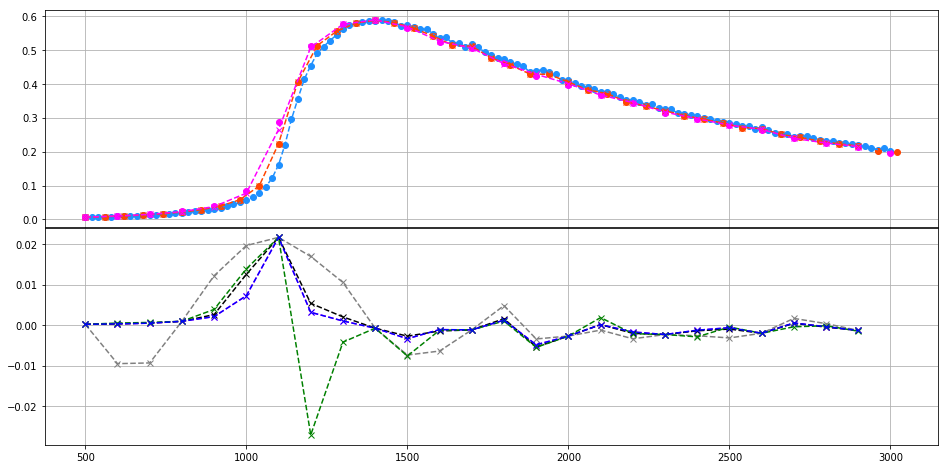

1 0
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
(0.003858441269545474, 1.0)
(0.006810908907426684, 1.0)
(0.07237510305537734, 1.0)
(0.01069436646826394, 1.0)
(0.0038584412695454764, 1.0)


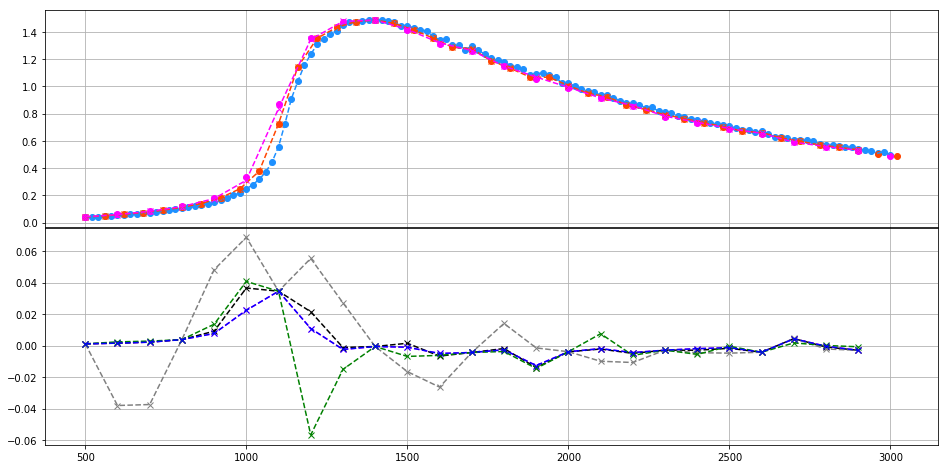

1 1
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
(0.008267559615552077, 1.0)
(0.014780398230688356, 1.0)
(0.149433200676895, 1.0)
(0.019958050090128066, 1.0)
(0.008267559615552077, 1.0)


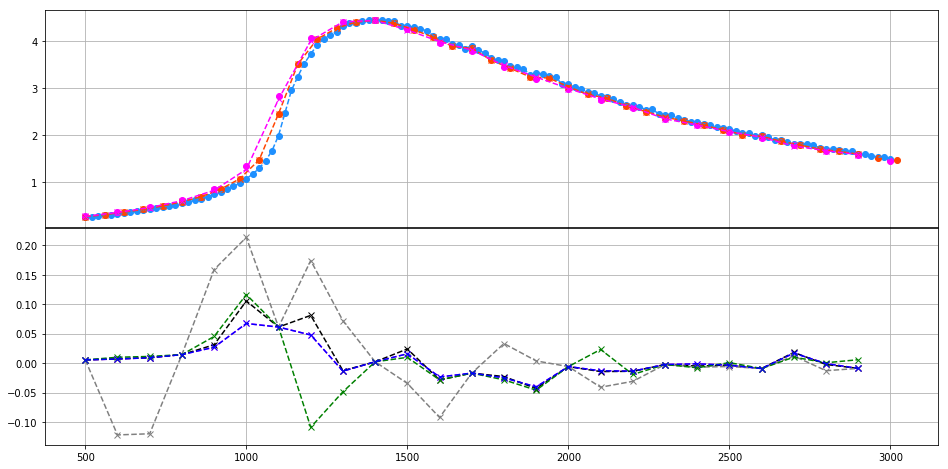

In [10]:
if calcValues == False:
    for i in range(0,2):#len(errorMatrixAbsolut)):
        for j in range(0, i+1):
            print i, j
            print onlyfiles[i]
            print onlyfiles[j]
            
            f = plt.figure(figsize=(16,12))
            plt.subplots_adjust(hspace=0.001)
            
            ax1 = plt.subplot(311)
            ax1.grid(True)     
            ax1.set_xlim(800, 1500)
            #ax1.set_xlim(1500, 3000)

            ax1.plot(axisArr,  integralMatrix[i][j].real,  'o', color='dodgerblue')
            ax1.plot(axisArr1, integralMatrix1[i][j].real, 'o', color='orangered')
            ax1.plot(axisArr2, integralMatrix2[i][j].real, 'o', color='fuchsia')
            
            
            interpolateValue = integralMatrix1[i,j][:-2] - integralMatrix[i,j][:-3:3]
            f=interp1d(axisArr1[:-2], interpolateValue.real, kind='linear')
            f1=interp1d(axisArr1[:-2], interpolateValue.real, kind='cubic')
            f2=interp1d(axisArr1[:-2], interpolateValue.real, kind='quadratic')
            f3=interp1d(axisArr1[:-2], interpolateValue.real, kind='zero')
            f4=interp1d(axisArr1[:-2], interpolateValue.real, kind='slinear')
            ax1.plot(axisArr, integralMatrix[i][j].real, '--', color='dodgerblue')           
            #ax1.plot(axisArr[:-5], integralMatrix[i][j][:-5].real + f(axisArr[:-5]), 'x--', color='black')
            ax1.plot(axisArr[:-3:3], integralMatrix[i][j][:-3:3].real + f(axisArr[:-3:3]), 'x--', color='orangered')
            #ax1.plot(axisArr[:-3:3], integralMatrix[i][j][:-2].real + f(axisArr[:-2])/60*100, '--', color='black')
            ax1.plot(axisArr2[:-1], integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100, 'x--', color='fuchsia')

            #f=interp1d(axisArr1, integralMatrix1[i][j].real, kind='cubic')
            #ax1.plot(axisArr2,  f(axisArr2),  '-', color='black')
            
            ax2 = plt.subplot(312, sharex=ax1)
            ax2.grid(True)
            #ax2.plot(axisArr[:-3:3], integralMatrix1[i,j][:-2]-(integralMatrix[i][j][:-3:3].real + f(axisArr[:-3:3])), 'x--', color='orangered')
            ax2.plot(axisArr2[:-1], integralMatrix2[i,j][:-1].real-(integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100), 'x--', color='fuchsia')
            ax2.plot(axisArr2[:-1], integralMatrix2[i,j][:-1].real-(integralMatrix[i][j][:-3:5].real + f1(axisArr2[:-1])/60*100), 'x--', color='black')
            ax2.plot(axisArr2[:-1], integralMatrix2[i,j][:-1].real-(integralMatrix[i][j][:-3:5].real + f2(axisArr2[:-1])/60*100), 'x--', color='grey')
            ax2.plot(axisArr2[:-1], integralMatrix2[i,j][:-1].real-(integralMatrix[i][j][:-3:5].real + f3(axisArr2[:-1])/60*100), 'x--', color='green')
            ax2.plot(axisArr2[:-1], integralMatrix2[i,j][:-1].real-(integralMatrix[i][j][:-3:5].real + f4(axisArr2[:-1])/60*100), 'x--', color='blue')
            print chisquare((integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100).real, f_exp=integralMatrix2[i,j][:-1].real)
            print chisquare((integralMatrix[i][j][:-3:5].real + f1(axisArr2[:-1])/60*100).real, f_exp=integralMatrix2[i,j][:-1].real)
            print chisquare((integralMatrix[i][j][:-3:5].real + f2(axisArr2[:-1])/60*100).real, f_exp=integralMatrix2[i,j][:-1].real)
            print chisquare((integralMatrix[i][j][:-3:5].real + f3(axisArr2[:-1])/60*100).real, f_exp=integralMatrix2[i,j][:-1].real)
            print chisquare((integralMatrix[i][j][:-3:5].real + f4(axisArr2[:-1])/60*100).real, f_exp=integralMatrix2[i,j][:-1].real)

            
            
            plt.show()
            
            

In [149]:
print chisquare((integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100).real, f_exp=integralMatrix2[i,j][:-1].real)
print type(integralMatrix2[i,j][:-1]-(integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100))
print integralMatrix2[i,j][:-1]-(integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100).real
print integralMatrix2[i,j][:-1].real-(integralMatrix[i][j][:-3:5].real + f(axisArr2[:-1])/60*100)

(0.008267559615552077, 1.0)
<type 'numpy.ndarray'>
[ 0.00545021+0.j  0.00697011+0.j  0.00901453+0.j  0.01442565+0.j
  0.02692883+0.j  0.06727577+0.j  0.06121238+0.j  0.04776447+0.j
 -0.01368078+0.j  0.00218432+0.j  0.01580596+0.j -0.02355497+0.j
 -0.01702261+0.j -0.02500319+0.j -0.04038223+0.j -0.00591424+0.j
 -0.01306221+0.j -0.01368279+0.j -0.00240602+0.j -0.00124028+0.j
 -0.00359802+0.j -0.00922589+0.j  0.01696739+0.j -0.00084654+0.j
 -0.00896362+0.j]
[ 0.00545021  0.00697011  0.00901453  0.01442565  0.02692883  0.06727577
  0.06121238  0.04776447 -0.01368078  0.00218432  0.01580596 -0.02355497
 -0.01702261 -0.02500319 -0.04038223 -0.00591424 -0.01306221 -0.01368279
 -0.00240602 -0.00124028 -0.00359802 -0.00922589  0.01696739 -0.00084654
 -0.00896362]
